In [28]:
import pandas as pd
import sys

# sys.path.append("./practice/covid19")

df = pd.read_csv("./dataset/Delaware.csv")
# df = df[df.REGION == "New York"]

df_use = df[["REGION", "YEAR", "WEEK", "ili_ratio"]]
df_use.index = range(len(df_use))

df_use = (df_use.loc[:, ["ili_ratio"]])  # 只用ili_ratio
df_use

,ili_ratio
0,0.001001
1,0.003686
2,0.003370
3,0.004605
4,0.002223
...,...
624,0.011423
625,0.009824
626,0.009270
627,0.012565


In [16]:
df = pd.read_csv("./dataset/covid19/france_new_cases.csv")

df_use = df[["New_cases"]]
df_use = df_use[200:]
df_use.index = range(len(df_use))

df_use

,New_cases
0,14223
1,12752
2,11635
3,11942
4,4773
...,...
791,14204
792,6766
793,64772
794,49188


In [29]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, device):
        super(CNN, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2),  # 24 - 2 + 1 = 23
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),  # 23 - 2 + 1 = 22
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2),  # 22 - 2 + 1 = 21
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),  # 21 - 2 + 1 = 20
        )
        self.Linear1 = nn.Linear(32 * 20, 50)
        self.Linear2 = nn.Linear(50, 1)
        self.device = device

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # print(x.size())  # 15 127 20
        x.to(self.device)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = x.view(x.shape[0], -1)

        return x

In [30]:
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import numpy as np
import torch

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

def nn_seq_us(batch_size):
    print('data processing...')
    dataset = df_use
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.85)]
    test = dataset[int(len(dataset) * 0.85):len(dataset)]
    m, n = np.max(train[train.columns[0]]), np.min(train[train.columns[0]])

    def process(data, batch_size, shuffle):
        load = data[data.columns[0]]
        load = load.tolist()
        data = data.values.tolist()
        load = (load - n) / (m - n)
        seq = []
        for i in range(len(data) - 24):
            train_seq = []
            train_label = []
            for j in range(i, i + 24):
                x = [load[j]]
                train_seq.append(x)
            # for c in range(2, 8):
            #     train_seq.append(data[i + 24][c])
            train_label.append(load[i + 24])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        # print(seq[-1])
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=True)

        return seq

    data_train = process(train, batch_size, True)
    data_validate = process(val, batch_size, True)
    data_test = process(test, batch_size, False)

    return data_train, data_validate, data_test, m, n

In [31]:
from torch.optim.lr_scheduler import StepLR as StepLR
from tqdm import tqdm
from copy import deepcopy

def get_val_loss(model, Val, loss_function, device):
    model.eval()
    val_loss = []
    for (seq, label) in Val:
        seq = seq.to(device)
        label = label.to(device)
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        val_loss.append(loss.item())

    return sum(val_loss)/len(val_loss)# MSE


def cnn_train(data_train, Val, path, optimizer = 'adam', max_epochs = 20, lr = 0.01, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):

    weight_decay = 0.003
    step_size = 5
    gamma = 0.1


    model = CNN(device).to(device)

    loss_function = nn.MSELoss().to(device)
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                     weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=0.9, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in range(max_epochs):
        train_loss = []
        for (seq, label) in data_train:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        # validation
        val_loss = get_val_loss(model, Val, loss_function, device)
        if epoch > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = deepcopy(model)

        if epoch % 10 == 0:
            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

In [32]:
input_size=1
hidden_size=10
num_layers=3
output_size = 1
batch_size = 5
optimizer = 'adam'
max_epochs = 50
lr = 0.002
lr = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

model_path = './cnn_model/best_model_lstm.model'

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size)

cnn_train(data_train, data_validate, model_path, optimizer, max_epochs, lr, device)

cpu
data processing...
epoch 000 train_loss 0.02247023 val_loss 0.01662314
epoch 010 train_loss 0.00678221 val_loss 0.01164324
epoch 020 train_loss 0.00642920 val_loss 0.00888276
epoch 030 train_loss 0.00642670 val_loss 0.01157466
epoch 040 train_loss 0.00641554 val_loss 0.01157141


In [64]:
from itertools import chain
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def get_mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# def lstm_test(data_test, path, m, n, input_size = 1,  hidden_size = 10, num_layers = 2, output_size = 1, batch_size = 5, device = torch.device('cpu')):
def cnn_test(data_test, path, m, n, device):
    pred = []
    y = []
    print('loading models...')

    model = CNN(device).to(device)

    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for (seq, target) in data_test:
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('mape:', get_mape(y, pred))
    print('mse:', get_mse(y, pred))

    # plot
    x = [i for i in range(1, y.shape[0] + 1)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred)(x_smooth)
    plt.plot(x_smooth-1, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    # plt.savefig("./new.png")
    plt.plot(25,0.010, c='blue', marker="*", ms=10, alpha=1, label="warning")
    plt.plot(11,0.0055, c='blue', marker="*", ms=10, alpha=1, label="warning")
    plt.plot(40,0.0025, c='blue', marker="*", ms=10, alpha=1, label="warning")
    plt.plot(62,0.003, c='blue', marker="*", ms=10, alpha=1, label="warning")
    plt.show()



loading models...
predicting...
mape: 45.028970208473766
mse: 3.828622172193021e-05


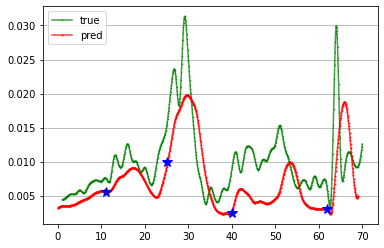

In [65]:
cnn_test(data_test, model_path, m, n, device)